In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import math

load data:

In [2]:
aus_basins = pd.read_excel('aus_basins_climate_zonalstats.xlsx') 
# octopus separates australia from the "international" dataset

In [3]:
int_basins = pd.read_excel('int_basins_climate_zonalstats.xlsx')

In [4]:
frames = [aus_basins, int_basins]
octBasins = pd.concat(frames)
# combine into one

Pull climate variables:

In [5]:
octBasins_lat = abs(octBasins['y_wgs84'])
# a series containing: basins absolute latitute 

In [6]:
octBasins_MAP = octBasins['MAP_mean']
# a series containing: basin-averaged MAP
print ('range:')
print (octBasins_MAP.min())
print (octBasins_MAP.max())

range:
0.09090909090909091
7041.384615384615


In [7]:
octBasins_MAT = octBasins['MAT_mean']
# a series containing: basin-averaged MAT
print ('range:')
print (octBasins_MAT.min())
print (octBasins_MAT.max())

range:
-10.30638891855876
27.40178544180734


In [8]:
octBasins_Pmax = octBasins['Pmax_mean']
# a series containing: basin-averaged max precip in wettest month
print ('range:')
print (octBasins_Pmax.min())
print (octBasins_Pmax.max())

range:
0.09090909090909091
2496.461538461539


In [9]:
octBasins_Tmax = octBasins['Tmax_mean']
# a series containing: basin-averaged max temp in hottest month
print ('range:')
print (octBasins_Tmax.min())
print (octBasins_Tmax.max())

range:
5.92000002861023
41.6000001695421


In [10]:
monthly_P = octBasins_MAP/12
print ('range:')
print (monthly_P.min())
print (monthly_P.max())

range:
0.007575757575757576
586.7820512820513


In [48]:
# new data frame containing variables used to calculate CWP
data = zip(monthly_P, octBasins_Pmax, octBasins_MAT, octBasins_Tmax)
climate_variables = pd.DataFrame(data=data, columns=['P','Pmax','T','Tmax'])
climate_variables = climate_variables.round(2) # get rid of the crazy decimals

In [49]:
climate_variables.head() # view first 5 rows of df

,P,Pmax,T,Tmax
0,30.15,60.65,20.63,35.47
1,33.17,42.51,15.58,30.51
2,118.88,325.97,27.35,35.51
3,30.14,60.65,20.63,35.47
4,89.28,127.50,11.07,23.04


In some cases, P might exceed Pmax or T might exceed Tmax. Conditionally modify P,T to be Pmax, Tmax:

In [13]:
## tried this fix, but it wasn't causing the issue 

#climate_variables = climate_variables.where(climate_variables['P'] < climate_variables['Pmax'], climate_variables['Pmax'], axis=0)
#climate_variables = climate_variables.where(climate_variables['T'] < climate_variables['Tmax'], climate_variables['Tmax'], axis=0)

Function to calculate CWP:

In [78]:
def calculate_CWP(P, Pmax, T, Tmax):
    return ((P/Pmax)**0.5)*math.exp(0.2265557*((1/T)-(1/Tmax)))

In [79]:
calculate_CWP(30,60,-5,5) # checking the first row of variables

0.6458449171960916

In [70]:
# for each row in df: climate variables,
# calculate CWP

CWP = climate_variables.apply(lambda r:
            calculate_CWP(P=r['P'], # p = p
                         Pmax=r['Pmax'], # pmax = pmax
                         T=r['T'], # t = t
                         Tmax=r['Tmax']), # tmax = tmax
            axis=1)

In [71]:
# add column to df containing CWP for each row

climate_variables['CWP']=CWP

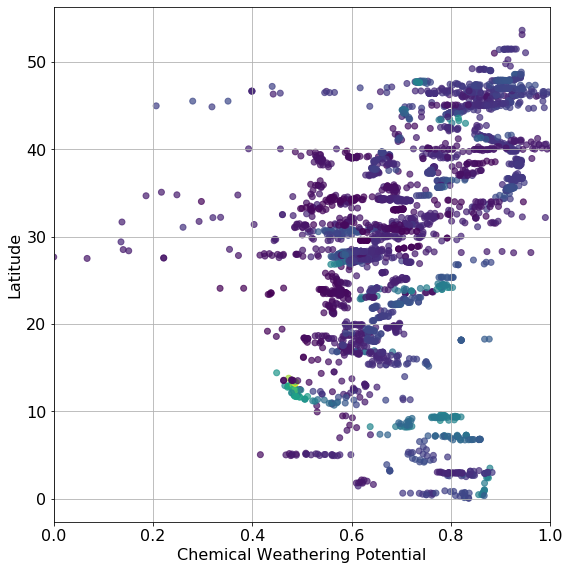

In [81]:
# plot results vs. latitude

rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.grid'] = True
rcParams['axes.labelsize'] = 16

fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(CWP, octBasins_lat, c=octBasins_MAP, alpha=0.7)
ax.set_xlabel('Chemical Weathering Potential')
ax.set_ylabel('Latitude')
ax.set_xlim(0,1) # hash off to see values of CWP >1

plt.tight_layout(True)
plt.savefig('CWP_xlim_greater_than_1.png')
plt.show()

In [74]:
# which sites have CWP >1?

wrong = climate_variables['CWP']> 1
climate_variables[wrong]

,P,Pmax,T,Tmax,CWP
186,48.85,124.84,0.43,15.41,1.043972
196,50.49,127.32,0.06,14.47,27.053253
333,54.05,133.66,0.19,13.24,2.059765
338,56.63,138.23,0.31,13.13,1.306537
523,38.26,89.49,0.29,13.58,1.404502
665,64.43,143.64,0.41,14.25,1.145465
675,58.91,141.21,0.33,14.51,1.263392
685,62.95,160.23,0.42,12.24,1.055246
929,97.13,141.82,1.04,13.54,1.011926
931,104.05,153.58,0.15,12.19,3.658711
